<a href="https://colab.research.google.com/github/DAVIDnHANG/DS-Unit-2-Kaggle-Challenge/blob/master/module2/M2Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
##################################
#understand how categorical encodings affect trees differently compared to linear models
###############################################################################################
#ordinary encoding with a linear model###
#Decision tree are great for non=linear models. Maybe a ranking?
#

##Decision tree are great for data that looks linear. non-montonic, going up and down.
##

#pass a mapping to ordinary encoding to know what the number represeented.


#  decisions tree with ordinary - split is determine with more variable. 
# do not use ordinary coding with linear model unless there is a rank.

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

#if your're in colab
if in_colab:
    #pull files from gthub repo
    os.chdir('/content')
    !git init
    !git remote add origin https://github.com/LabdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    #install required python packages
    !pip install -r requirement
    
    #change into directory for module
    os.chdir('module2')

In [0]:
import pandas as pd
import numpy as np
#import pandas as pd
import os
from sklearn.model_selection import train_test_split
#uploaded = files.upload()
#then change the filepath buffer once the file is in google.colab. also remove the file.upload() function

#name the column, adding informative names to features
#data has no header, and no footheader
#train= pd.merge(pd.read_csv('/content/test_features.csv'), pd.read_csv('/content/train_labels.csv'))
train_label_df = pd.merge(pd.read_csv('../m2w2 kaggle/train_features.csv'),  pd.read_csv('../m2w2 kaggle/train_labels.csv'))
#label =pd.read_csv('/content/train_labels.csv')
#train= pd.read_csv('/content/train_features.csv')
test_df = pd.read_csv('../m2w2 kaggle/test_features.csv')
submission_df = pd.read_csv('../m2w2 kaggle/sample_submission.csv')


In [0]:
train_label_df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


train_test_split

In [0]:
from sklearn.model_selection import train_test_split
#Let Train, Validate, test then set features,target on .75 .25
train, validate = train_test_split(train_label_df, train_size = 0.75, test_size =0.25, random_state=42)
train.shape, validate.shape, test_df.shape
#I am using whole test_df to test. so let reword test_df to simply test
test = test_df
train.shape, validate.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [0]:
#let remove that
import numpy as np

def wrangle(X):
  #I will set boundries latitude (25,33), longitude (-14, 0)
  X=X.copy()
  #use number inbetween Long(25,44)   Lat (-14,0)     # can also use the replace method. many ways to do this.
  ###############################################################################
  #mask = ((X['longitude'] >= 22) & (X['longitude']<=44)) | ((X['latitude'] >= 1) & (X['latitude']<=-20))
  #X = X.loc[mask]
  ######################################################################
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
  #rename 'status_group'
  X = X.rename(columns={'status_group':'status'})

  #Filter the dataframe with columns that has _group or _type in the syntax, then only list these columns.
  #Then Drop them because columns with _group or _type are duplicate of the original name that doesn't have those substring
  X = X.drop(X.filter(regex='_group').columns, axis=1)
  X = X.drop(X.filter(regex='_type').columns, axis=1)

  X = X.drop(columns=['basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'management','quantity'])
  return X

train = wrangle(train)
validate = wrangle(validate)
test = wrangle(test)

In [0]:
train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,lga,ward,population,scheme_name,construction_year,payment,water_quality,source,source_class,status
24947,33935,20.0,2011-03-08,Government Of Tanzania,330,Ce,38.123839,-6.087137,Ccm,0,...,Bagamoyo,Mbwewe,80,Kwaruhombo wa,1972,pay per bucket,salty,machine dbh,groundwater,non functional
22630,49654,0.0,2013-02-16,Dwsp,0,DWE,NaN,NaN,Mwamahonza,0,...,Magu,Nkungulu,0,NaN,0,unknown,soft,shallow well,groundwater,functional
13789,39287,0.0,2011-08-13,Dasip,0,DASIP,33.312321,-2.814100,Chanongu,0,...,Kwimba,Wala,0,NaN,0,never pay,soft,machine dbh,groundwater,functional


In [0]:
target = 'status'

train_features = train.drop(columns=[target,'id'])
#In the dataframe, grab all the numeric columns, then list it into columns. Finally turn it into array.
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
#This (not a number) columns has how many unique categories?
cardinality = train_features.select_dtypes(exclude='number').nunique()
#if this columns has less than 50 keep that column, and turn it into array. (important step for panda ARRAY)
categorical_features = cardinality[cardinality <= 50].index.tolist()
#combine the list
features = numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]

X_validate = validate[features]
y_validate = validate[target]

X_test = test[features]


#random forest

In [0]:
train.dtypes

id                     int64
amount_tsh           float64
date_recorded         object
funder                object
gps_height             int64
installer             object
longitude            float64
latitude             float64
wpt_name              object
num_private            int64
subvillage            object
region_code            int64
district_code          int64
lga                   object
ward                  object
population             int64
scheme_name           object
construction_year      int64
payment               object
water_quality         object
source                object
source_class          object
status                object
dtype: object

In [0]:
#########################################################################
##                 OneHotEncoder
##                 SimpleIMputer
##              RandomForest classifier
#########################################################################

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline_OneHotEncoder_Random_Forest = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1) # more votes being cast if i increase n_estimators
)#n_estimator is how many trees. 

pipeline_OneHotEncoder_Random_Forest.fit(X_train, y_train)
print('Validation accuracy', pipeline_OneHotEncoder_Random_Forest.score(X_validate,y_validate))

Validation accuracy 0.7213468013468013


In [0]:
#             how many true positive is in one group or the others            ####
#          what decision is being split on                         #######

########################################################################
import matplotlib.pyplot as plt
%matplotlib inline

random_forest = pipeline_OneHotEncoder_Random_Forest.named_steps['randomforestclassifier']
encoder = pipeline_OneHotEncoder_Random_Forest.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

#what is importances? 
features_precentage_contribution=pd.Series(random_forest.feature_importances_, encoded.columns)

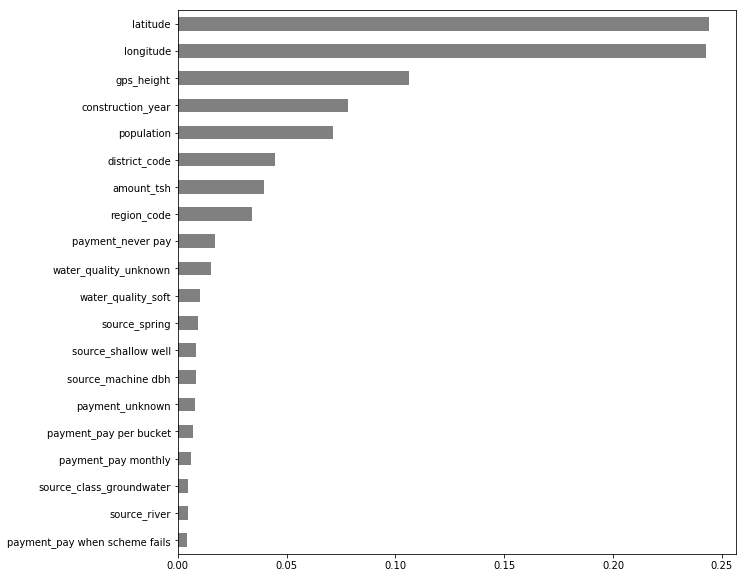

In [0]:
#pipeline
n = 20 
plt.figure(figsize=(10,10))
features_precentage_contribution.sort_values()[-n:].plot.barh(color='grey')

In [0]:
#Latitude, long, gps_heigt, construciton_year, population, district_code, amount_tsh, region_code, and who pays. I think population
#                   encoding with High-cardinality categoricals                     #

In [0]:
#                   encoding with High-cardinality categoricals                     #
######################################################################
############
############
############
##############################################################


X_train_ordinal = train.drop(columns=target)
y_train_ordinal = train[target]
X_validate_ordinal = validate.drop(columns=target)
y_validate_ordinal = validate[target]
X_test_ordinal = test

pipeline_ordinal = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1) # more votes being cast if i increase n_estimators
)#n_estimator is how many trees. 

pipeline_ordinal.fit(X_train_ordinal,y_train_ordinal )
print('validation accuracy', pipeline_ordinal.score(X_validate_ordinal, y_validate_ordinal))

#for every catagory variable, it only taking up one column.
#the hotencoder will take up one column for every unique value.
#let look at bar graph with ordinal encoders.


validation accuracy 0.7053198653198653


In [0]:
#how many true positive is in one group or the others
#what decision is being split on
import matplotlib.pyplot as plt
%matplotlib inline

random_forest = pipeline_ordinal.named_steps['randomforestclassifier']
encoder = pipeline_ordinal.named_steps['ordinalencoder']
encoded = encoder.transform(X_train_ordinal)

#what is importances? 
features_precentage_ordinal=pd.Series(random_forest.feature_importances_, encoded.columns)

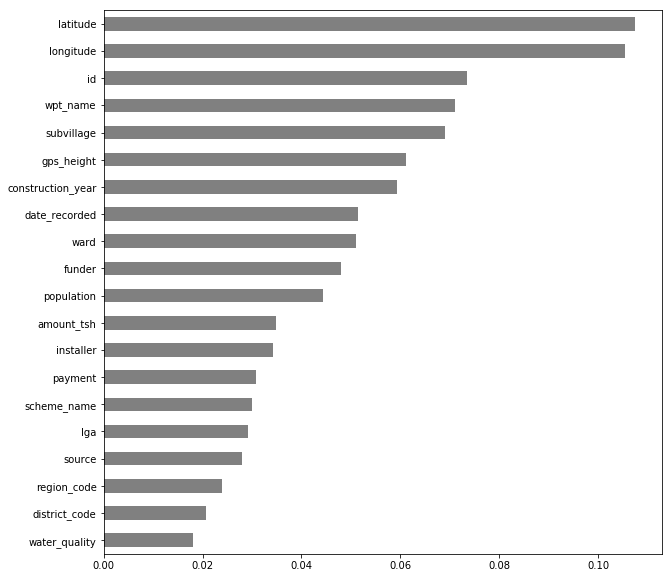

In [0]:
###############       pipeline            #####################
n = 20 
plt.figure(figsize=(10,10))
features_precentage_ordinal.sort_values()[-n:].plot.barh(color='grey')

In [0]:
#lat long id wpt_name subvillage, gps_height, constuction_year, date_recorded, ward, funder, 
#population, amount_tsh. installer

C:\Users\D3MoNa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


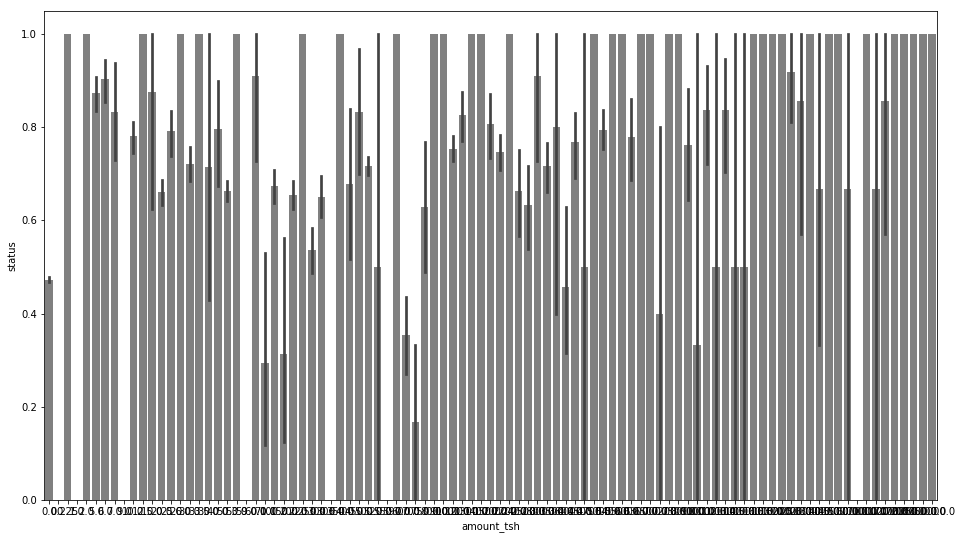

In [0]:
#tree ensembles
features_for_tree = 'amount_tsh'
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[features_for_tree],
    y=train['status']=='functional', #true-false conditional statement. True then count.
    color='grey'
);

In [0]:
###############################
#         Accuracy is only slightly improved over the simple
#
############################
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
 
Pipeline_Ordinal_Logistic_Regression = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegressionCV(multi_class='auto',solver='lbfgs',cv=5,n_jobs=-1)
)
#fit only on the 'amount_tsh' variables
Pipeline_Ordinal_Logistic_Regression.fit(X_train[features_for_tree], y_train)
score = Pipeline_Ordinal_Logistic_Regression.score(X_validate[features_for_tree], y_validate)
print("Ordinal, Logistic Regression accuracy", score)
print("OrdinalEncoder just goes faster and has less column than OnOneHotEncoder.")

Ordinal, Logistic Regression accuracy 0.5453198653198653
OrdinalEncoder just goes faster and has less column than OnOneHotEncoder.


In [0]:
################################################################################################
############                     Ordinal encoding
############                     Decision Tree
############                     validate accuracy
################################################################################################
from sklearn.tree import DecisionTreeClassifier

pipeline_Ordinal_DecisionTree = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)
pipeline_Ordinal_DecisionTree.fit(X_train[features_for_tree], y_train)
score = pipeline_Ordinal_DecisionTree.score(X_validate[features_for_tree], y_validate)
print('Ordinal, decision Tree', score)



Ordinal, decision Tree 0.5458585858585858


In [0]:
#let look at decision tree model
#ordinal encoding with decision tree
from sklearn.tree import export_graphviz

model = pipeline_Ordinal_DecisionTree.named_steps['decisiontreeclassifier']
encoder = pipeline_Ordinal_DecisionTree.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_validate[[features_for_tree]]).columns

dot_data = export_graphviz(
    model,
    out_file=None,
    max_depth=5,
    feature_names=encoded_columns,
    class_names=model.classes_,
    impurity=False,
    filled=True,
    proportion=True,
    rounded=True
)
display(graphviz.Source(dot_data))

NameError: name 'graphviz' is not defined

In [0]:
y_pred = pipeline_OneHotEncoder_Random_Forest.predict(X_test)

In [0]:
submission_df['status_group']=y_pred
submission_df.to_csv('submission.csv', index=False)
